In [1]:
import json
import pandas as pd
import numpy as np
import os.path
import convertCSV2JSON as c2j
from PhonoSearchLib import LangSearchEngine
from scipy.spatial import Delaunay
from string import capwords
from IPAParser import parseCons, parsePhon

In [2]:
join_by_comma = lambda x: ', '.join(str(el) for el in x)
to_lower = lambda x: x.lower()
map_to_list = lambda x, func: list(map(func, x))

Exponential density (= neighbour pressure) function.
The function works as an accumulator function:
it augments the neighbour-pressure metric based on
whether a node in the graph has the relevant property
and its distance from the node of interest.

The general formula is

$$NP = \sum_{l \in L, l \ne l_0} \frac{i_l}{e^{d_l}}$$

I.e., every language in the sample except the language of interest
($l_0$) possessing the feature of interest ($i_l = 1$, otherwise $i_l = 0$) contributes
to the neighbour pressure in the proportion inverse to its distance
($d_l$) from the language of interest in the neighbour graph.

In [3]:
def exponential_density(accum ,dist):
    return accum + 1.0/np.exp(dist)

Pseudo-exponential density for any base, in this case $2$ is used:

$$NP = \sum_{l \in L, l \ne l_0} \frac{i_l}{2^{d_l}}$$

In [4]:
def pseudo_exponential_density(accum, dist, k):
    return accum + 1.0/(k**dist)
exp_dens_base_2 = lambda accum, dist: pseudo_exponential_density(accum, dist, 2)

In [5]:
# Get a list of points for a given feature
def get_point_list(query_string, search_engine, points_dict):
    lang_list = big_engine.features_query(query_string)
    temp = []
    for el in lang_list:
            temp.append(el)
    return [ names_dict[l.split('#')[0]] for l in temp ]

In [6]:
# Compute a density distribution for a given feature of interest in the neighbour graph.
# Feature of interest is represented by a list of points possessing this feature.
def compute_density_distribution(lang_graph, points_list, accumulator_fun):
    distr_dict = {}
    for node in lang_graph.nodes():
        statistic = 0
        for p in points_list:
            # The points not possessing the feature add 0 to the metric.
            # Some points could be missing from the lang_graph
            # due to their extreme geographic isolation.
            if p not in lang_graph: continue
            # Presence of feature of interest in the node, for which
            # the metric is computed, is ignored.
            if node != p:
                try:
                    dist = nx.shortest_path_length(lang_graph, node, p)
                    statistic = accumulator_fun(statistic, dist)
                except nx.NetworkXNoPath:
                    # The point belongs to a different component.
                    continue
        distr_dict[node] = statistic
    return distr_dict

In [7]:
# Compute a density distribution for a given feature of interest in the neighbour graph
# taking into account only languages from the same phylum as the language of interest.
def compute_density_distribution_from_the_same_phylum(lang_graph,
                                                      points_list,
                                                      accumulator_fun,
                                                      phylo_dic,
                                                      names_arr):
    distr_dict = {}
    for node in lang_graph.nodes():
        node_phylum = phylo_dic[names[node]][0]
        statistic = 0
        for p in points_list:
            # Points not possessing the feature add 0 to the metric.
            # Some points could be missing from the lang_graph
            # due to their extreme geographic isolation.
            if p not in lang_graph: continue
            # Presence of feature of interest in the node, for which
            # the metric is computed, is ignored.
            if node != p:
                p_phylum = phylo_dic[names[p]][0]
                # Exclude languages from other phyla
                if p_phylum == node_phylum:
                    try:
                        dist = nx.shortest_path_length(lang_graph, node, p)
                        statistic = accumulator_fun(statistic, dist)
                    except nx.NetworkXNoPath:
                        # The point belongs to a different component.
                        continue
        distr_dict[node] = statistic
    return distr_dict

In [6]:
# Data from EURPhon
engine = LangSearchEngine('dbase/phono_dbase.json', False)

# PHOIBLE data except those langs that are present
# in EURPhon or are taken from SPA (they overlap with UPSID)
lang_data = pd.read_csv('phoible-aggregated.tsv', sep='\t')
phon_data = pd.read_csv('phoible-phonemes.tsv', sep='\t')
eur_lang_codes = [el['code'] for el in engine.lang_dic.values()]
sample = lang_data[lang_data['Area'].isin(['Asia', 'Europe']) &
                   ~lang_data['Country'].isin(['Indonesia', 'Malaysia', 'Brunei']) &
                   ~lang_data['LanguageCode'].isin(eur_lang_codes) &
                   ~lang_data['Source'].isin(['SPA'])]

# Unification of phylum and genus names
with open('phoible_groups_to_langs.json', 'r', encoding='utf-8') as inp:
    groups_to_fams = json.load(inp)

sample_codes = sample['LanguageCode'].unique()
sample_names = map_to_list(sample['LanguageName'].unique(), to_lower)

# Extract consonant data from PHOIBLE
phono_sample = phon_data[(phon_data['LanguageCode'].isin(sample_codes) |
                         phon_data['LanguageName'].apply(to_lower).isin(sample_names)) &
                         ~phon_data['Source'].isin(['SPA']) &
                         phon_data['Class'].isin(['consonant'])]
phono_sample = phono_sample[['LanguageCode', 'LanguageName', 'Phoneme']]

/Users/macbook/miniconda2/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
# Throw away languages with non-IPA symbols in the descriptions
lang_blacklist = set()
for i, p in enumerate(phono_sample['Phoneme']):
    try:
        parsePhon(p)
    except Exception as error:
        print(phono_sample.iloc[i,])
        lang_blacklist.add(capwords(phono_sample.iloc[i,]['LanguageName'].lower()))
lang_blacklist = list(lang_blacklist)
# lang_blacklist

LanguageCode      aqc
LanguageName    ARCHI
Phoneme           *R̪
Name: 8460, dtype: object
LanguageCode         cbn
LanguageName    NYAH KUR
Phoneme             *R̪̥
Name: 9868, dtype: object
LanguageCode         cbn
LanguageName    NYAH KUR
Phoneme              *R̪
Name: 9870, dtype: object
LanguageCode    pcc
LanguageName    YAY
Phoneme         *R̪
Name: 17525, dtype: object
LanguageCode        sqt
LanguageName    SOCOTRI
Phoneme             *R̪
Name: 18843, dtype: object
LanguageCode        sqt
LanguageName    SOCOTRI
Phoneme            *R̪̰
Name: 18846, dtype: object


In [8]:
lang_blacklist

['Archi', 'Socotri', 'Yay', 'Nyah Kur']

In [9]:
# Convert the data to the language-per-row format
inventories = phono_sample.groupby('LanguageName').agg(join_by_comma)
inventories['LanguageCode'] = inventories['LanguageCode'].apply(lambda x: x.split(', ')[0])
inventories[inventories.index.name] = pd.Series(inventories.index).apply(capwords)
inventories['LanguageName'] = list(map_to_list(inventories.index, capwords))
inventories = inventories[~inventories['LanguageName'].isin(lang_blacklist)]

inventories['Phylum'] = None
inventories['Genus'] = None
inventories['Latitude'] = None
inventories['Longitude'] = None

genera = []
lats   = []
lons   = []
for i, ln in enumerate(inventories['LanguageName']):
    rows = lang_data[~lang_data['Source'].isin(['SPA']) &
                     (lang_data['LanguageName'].apply(capwords) == ln)]
    # All subsets are one-row long by definition,
    # cf. the groupby statement above
    genus = rows.iloc[0,]['LanguageFamilyGenus'].strip()
    inventories['Genus'][i] = genus
    phylum = groups_to_fams[genus]
    inventories['Phylum'][i] = phylum
    try:
        lat = float(rows.iloc[0,]['Latitude'].replace(':', '.'))
        inventories['Latitude'][i] = lat
    except:
        continue
    try:
        lon = float(rows.iloc[0,]['Longitude'].replace(':', '.'))
        inventories['Longitude'][i] = lon
    except:
        continue

# Add data needed by the EURPhon parser
# and rearrange columns
inventories['Timestamp'] = None
inventories['Lang_or_dial'] = "Язык"
inventories['Source'] = "PHOIBLE"
inventories['Source_short'] = None
inventories['Vowels'] = None
inventories['Tones'] = None
inventories['Syllables'] = None
inventories['Initial_clusters'] = None
inventories['Finals'] = None
inventories['Comments'] = None
inventories['Added_by'] = "PHOIBLE"

new_col_list = ['Timestamp',
                'LanguageName',
                'LanguageCode',
                'Latitude',
                'Longitude',
                'Lang_or_dial',
                'Phylum',
                'Genus',
                'Source',
                'Source_short',
                'Phoneme',
                'Vowels',
                'Tones',
                'Syllables',
                'Initial_clusters',
                'Finals',
                'Comments',
                'Added_by'
               ]

inventories = inventories[new_col_list]

# Dump the data in the new aggregated file
# for subsequent processing
with open('dbase/ffli-dbase.csv', 'r', encoding='utf-8') as inp:
    with open('all_data.csv', 'w', encoding='utf-8') as out:
        out.write(inp.read() + '\n')
        for i in range(inventories.shape[0]):
            out.write('\t'.join(str(el) for el in inventories.iloc[i,]) + '\n')

with open ('all_data.json', 'w', encoding='utf-8') as out:
    json.dump(c2j.convert2JSON("all_data.csv"), out, indent=4, ensure_ascii=False)

# Read the data and get the search engine going
big_engine = LangSearchEngine('all_data.json', False)

names = []
lats  = []
lons  = []
phyla = []
genera = []
inventory_sets = []
for key, val in big_engine.coord_dic.items():
    names.append(key.split('#')[0])
    lat, lon = val
    lats.append(lat)
    lons.append(lon)
    if lat == "None" or lon == "None":
        print(key)
    phyla.append(big_engine.lang_dic[key]['gen'][0])
    genera.append(big_engine.lang_dic[key]['gen'][1])
    inventory_sets.append(set(el.difference({'lateral', 'non_lateral'}) for el in big_engine.inv_dic[key] if 'consonant' in el))
coords_table = pd.DataFrame({'LangName': names, 'Latitude': lats, 'Longitude': lons,
                             'Phylum': phyla, 'Genus': genera})
coords_table = coords_table[['LangName', 'Latitude', 'Longitude', 'Phylum', 'Genus']]
coords_table.to_csv('all_data_coords.csv', index=False)

In [14]:
len(inventory_sets)

481

In [22]:
inventories.shape

(156, 18)

In [12]:
# The final sample size
coords_table.head()

LangName    Latitude   Longitude         Phylum  \
0       Skolt Saami (Suõʹnnʼjel)        68.5        29.5         Uralic   
1                Nganasan (Avam)        71.1        92.8         Uralic   
2                        Italian  41.9100711  12.5359979  Indo-European   
3  Norwegian (Standard Østnorsk)  59.8938549  10.7851165  Indo-European   
4                  Udihe (Bikin)       46.54      135.36       Tungusic   

               Genus  
0             Saamic  
1            Samoyed  
2            Romance  
3           Germanic  
4  Northern Tungusic

In [10]:
# Delaunay triangulation on a sphere = 3d convex hull

from scipy.spatial import ConvexHull

points_cartesian = np.ndarray((0, 3))
for i in range(len(lats)):
    lat = np.deg2rad(np.float(lats[i]))
    lon = np.deg2rad(np.float(lons[i]))
    x = np.cos(lat) * np.cos(lon)
    y = np.cos(lat) * np.sin(lon)
    z = np.sin(lat)
    points_cartesian = np.vstack((points_cartesian, (x, y, z)))

qhull = ConvexHull(points_cartesian)

In [14]:
for i in range(10):
    p1, p2, p3 = qhull.simplices[i]
    print(p1,p2,p3)
    print(names[p1], names[p2], names[p3])
    print(coords_table['LangName'][p1], coords_table['LangName'][p2], coords_table['LangName'][p3])

0 85 1
Skolt Saami (Suõʹnnʼjel) Tundra Yukaghir Nganasan (Avam)
Skolt Saami (Suõʹnnʼjel) Tundra Yukaghir Nganasan (Avam)
177 85 1
Sakha (Standard) Tundra Yukaghir Nganasan (Avam)
Sakha (Standard) Tundra Yukaghir Nganasan (Avam)
461 114 131
Southern Sama Mah Meri Dhivehi (Malé)
Southern Sama Mah Meri Dhivehi (Malé)
461 115 131
Southern Sama Portuguese (Estremenho) Dhivehi (Malé)
Southern Sama Portuguese (Estremenho) Dhivehi (Malé)
461 115 464
Southern Sama Portuguese (Estremenho) Tiruray
Southern Sama Portuguese (Estremenho) Tiruray
461 104 464
Southern Sama Tausug (Jolo) Tiruray
Southern Sama Tausug (Jolo) Tiruray
73 115 188
Spanish (Castilian) Portuguese (Estremenho) Maltese (Standard)
Spanish (Castilian) Portuguese (Estremenho) Maltese (Standard)
70 371 23
Uyghur (Xinjiang) Khalkha Eastern Yugur
Uyghur (Xinjiang) Khalkha Eastern Yugur
408 177 111
Manchu Sakha (Standard) Solon
Manchu Sakha (Standard) Solon
150 166 451
Finnish (Standard) Pite Saami Saami
Finnish (Standard) Pite Saami S

In [10]:
qhull.simplices.shape

(926, 3)

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [12]:
lats_float = list(map(np.float, lats))
lons_float = list(map(np.float, lons))

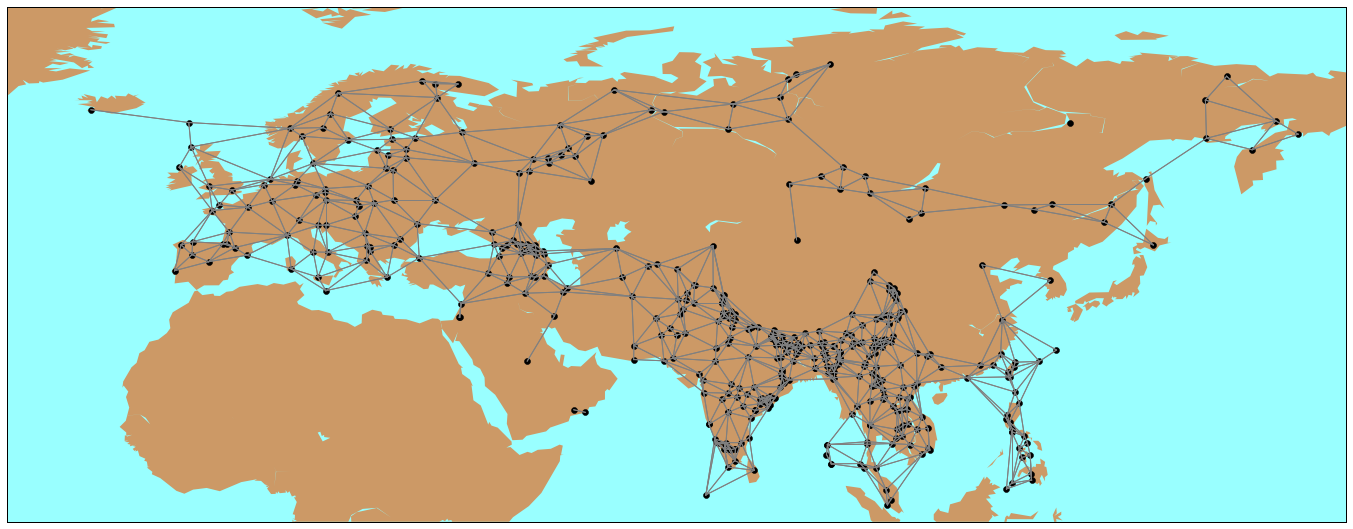

In [13]:
# Draw map for testing

from geopy.distance import VincentyDistance
from itertools import combinations
m = Basemap(llcrnrlon=-35.0, llcrnrlat=0, urcrnrlon=173, urcrnrlat=80)
x, y = m(
    lons_float,
    lats_float
)

plt.figure(figsize=(24,15))
m.drawmapboundary(fill_color='#99ffff')
m.fillcontinents(color='#cc9966',lake_color='#99ffff')
m.plot(x,y,'ko',markersize=6)
for i in range(qhull.simplices.shape[0]):   #(len(names)):
    for pair in combinations(qhull.simplices[i], 2):
        p = pair[0]; q = pair[1]
        lat1, lon1 = lats_float[p], lons_float[p]
        lat2, lon2 = lats_float[q], lons_float[q]
        d = VincentyDistance((lat1, lon1),
                             (lat2, lon2)).kilometers
        if d < 1000:
            plt.plot(
                [x[p], x[q]],
                [y[p], y[q]],
                '-', lw=1,
                color = 'grey'
            )
#         distances.append(d)

Check how many pairs of the 8 types ($\pm$same_genus, $\pm$neighbours) and ($\pm$same_phylum, $\pm$neighbours) there are in the data.

In [32]:
same_genus_neigh = {
    (False,False): 0,
    (False,True): 0,
    (True,False): 0,
    (True,True): 0,
}
same_phylum_neigh = {
    (False,False): 0,
    (False,True): 0,
    (True,False): 0,
    (True,True): 0,
}
for i in range(qhull.simplices.shape[0]):
    for pair in combinations(qhull.simplices[i], 2):
        p = pair[0]; q = pair[1]
        if coords_table['Genus'][p] == coords_table['Genus'][q]:
            same_genus_neigh[(True,True)] += 1
        else:
            same_genus_neigh[(False,True)] += 1
        if coords_table['Phylum'][p] == coords_table['Phylum'][q]:
            same_phylum_neigh[(True,True)] += 1
        else:
            same_phylum_neigh[(False,True)] += 1

In [36]:
from scipy.special import binom
for g in coords_table['Genus'].unique():
    genus_subset = coords_table.loc[coords_table['Genus'] == g]
    same_genus_neigh[(True,False)] += binom(genus_subset.shape[0], 2)
same_genus_neigh[(True,False)] -= same_genus_neigh[(True,True)]
for p in coords_table['Phylum'].unique():
    phylum_subset = coords_table.loc[coords_table['Phylum'] == p]
    same_phylum_neigh[(True,False)] += binom(phylum_subset.shape[0], 2)
same_phylum_neigh[(True,False)] -= same_phylum_neigh[(True,True)]

In [37]:
same_genus_neigh

{(False, False): 0,
 (False, True): 2024,
 (True, False): 1583.0,
 (True, True): 754}

In [38]:
same_phylum_neigh

{(False, False): 0,
 (False, True): 1134,
 (True, False): 15533.0,
 (True, True): 1644}

In [39]:
binom(coords_table.shape[0],2)

115440.0

In [41]:
115440 - sum(same_phylum_neigh.values())

97129.0

Measure how (dis)similar are neighbouring languages when the are related and not related.

Two metrics are used:
1. Jaccard
2. Closest-relative cumulative Jaccard (CRCJ)

## Jaccard

In [49]:
def jaccard_metric(set1, set2):
    return 1 - len(set1.intersection(set2))/len(set1.union(set2))

## CRCJ

In [76]:
def CRCJ(inv1, inv2):
    result = 0
    for el1 in inv1:
        min_dif = 1
        for el2 in inv2:
            current_dif = jaccard_metric(el1, el2)
            if current_dif < min_dif:
                min_dif = current_dif
        result += min_dif
    for el1 in inv2:
        min_dif = 1
        for el2 in inv1:
            current_dif = jaccard_metric(el1, el2)
            if current_dif < min_dif:
                min_dif = current_dif
        result += min_dif
    return result

In [ ]:
processed_pairs = set()
lang_pair     = []
neighbours    = []
same_phylum   = []
same_genus    = []
dissimilarity = []
crcj          = []
# Process all neighbours
for i in range(qhull.simplices.shape[0]):
    for pair in combinations(qhull.simplices[i], 2):
        p = pair[0]; q = pair[1]
        name_pair = (
                min(names[p], names[q]),
                max(names[p], names[q])
            )
        processed_pairs.add(name_pair)
        lang_pair.append(' vs. '.join(name_pair))
        neighbours.append(1)
        if coords_table['Phylum'][p] == coords_table['Phylum'][q]:
            same_phylum.append(1)
            if coords_table['Genus'][p] == coords_table['Genus'][q]:
                same_genus.append(1)
            else:
                same_genus.append(0)
        else:
            same_phylum.append(0)
            same_genus.append(0)
        dissimilarity.append(jaccard_metric(inventory_sets[p], inventory_sets[q]))
        crcj.append(CRCJ(inventory_sets[p], inventory_sets[q]))
# Process everything else
for pair in combinations(range(len(names)), 2):
    p = pair[0]; q = pair[1]
    name_pair = (
                min(names[p], names[q]),
                max(names[p], names[q])
            )
    if name_pair in processed_pairs:
        continue
    lang_pair.append(' vs. '.join(name_pair))
    neighbours.append(0)
    if coords_table['Phylum'][p] == coords_table['Phylum'][q]:
        same_phylum.append(1)
        if coords_table['Genus'][p] == coords_table['Genus'][q]:
            same_genus.append(1)
        else:
            same_genus.append(0)
    else:
        same_phylum.append(0)
        same_genus.append(0)
    dissimilarity.append(jaccard_metric(inventory_sets[p], inventory_sets[q]))
    crcj.append(CRCJ(inventory_sets[p], inventory_sets[q]))

In [79]:
jaccard_df = pd.DataFrame({'lang_pair': lang_pair, 'neighbours': neighbours,
                          'same_phylum': same_phylum, 'same_genus': same_genus,
                          'jaccard': dissimilarity, 'CRCJ': crcj})
jaccard_df = jaccard_df[['lang_pair', 'neighbours', 'same_phylum', 'same_genus', 'jaccard', 'CRCJ']]

In [80]:
jaccard_df_rounded = jaccard_df.round(3)
jaccard_df_rounded.to_csv('jaccard_df.csv', sep='\t', index=False)

In [23]:
place_names  = ['bilabial', 'labial-velar', 'labial-palatal', 'labiodental', 'interdental', 'alveolar',
                'postalveolar', 'hissing-hushing', 'retroflex', 'alveolo-palatal', 'palatal', 'palatal-velar',
                'velar', 'uvular', 'pharyngeal', 'glottal', 'epiglottal']
manner_names = ['plosive', 'implosive', 'nasal', 'trill', 'tap', 'lateral_tap', 'fricative',
                'lateral_fricative', 'approximant', 'lateral_approximant', 'affricate']
voice        = ['voiceless', 'voiced']
vot          = ['aspirated', 'glottalised'] # glottalisation is not strictly speaking
                                            # a VOT feature, but they do not seem to be contrastive
add_art      = ['palatalised', 'labialised']

In [24]:
# Enumerating interesting feature combinations
combs = []
for p in place_names:
    if p == 'glottal':
        for m in ['plosive', 'fricative']:
            if m == 'plosive': combs.append(' '.join([p, m]))
            else:
                for v in voice:
                    combs.append(' '.join([p, m, v]))
    else:
        for m in manner_names:
            for v in voice:
                query_string = ' '.join([p, m, v])
                if list(big_engine.features_query(query_string)):
                    combs.append(query_string)
                for a in add_art:
                    query_string = ' '.join([p, m, v, a])
                    if list(big_engine.features_query(query_string)):
                        combs.append(query_string)
                for vt in vot:
                    query_string = ' '.join([p, m, v, vt])
                    if list(big_engine.features_query(query_string)):
                            combs.append(query_string)
                for a in add_art:
                    for vt in vot:
                        query_string = ' '.join([p, m, v, vt, a])
                        if list(big_engine.features_query(query_string)):
                            combs.append(query_string)         

In [18]:
# Graph analysis
import networkx as nx
from itertools import combinations
from geopy.distance import VincentyDistance
lang_graph = nx.Graph()

for i in range(qhull.simplices.shape[0]):
    for pair in combinations(qhull.simplices[i], 2):
        p = pair[0]; q = pair[1]
        lat1, lon1 = lats_float[p], lons_float[p]
        lat2, lon2 = lats_float[q], lons_float[q]
        d = VincentyDistance((lat1, lon1),
                             (lat2, lon2)).kilometers
        if d < 1000:
            lang_graph.add_edge(p, q)

In [19]:
shortest_paths_dicts = {}
for n in lang_graph.nodes():
    shortest_paths_dicts[n] = nx.single_source_shortest_path_length(lang_graph, n)

In [20]:
names_dict = { name : i for i, name in enumerate(names) }
# names_dict

In [25]:
combs[0]

'bilabial plosive voiceless'

In [25]:
# Sample density distribution
dd_voiceless_nasal = compute_density_distribution(lang_graph,
                                                  get_point_list('voiceless nasal',
                                                                 big_engine,
                                                                 names_dict),
                                                  exp_dens_base_2)
#                                                   exponential_density)

In [26]:
dd_voiceless_nasal

{0: 0.6566585302352905,
 1: 0.010356038808822632,
 2: 0.19946110248565674,
 3: 0.562711775302887,
 4: 0.00032362621277570724,
 5: 0.05341148376464844,
 6: 2.0226638298481703e-05,
 7: 0.04684638977050781,
 8: 0.005178019404411316,
 9: 0.45397965610027313,
 10: 0.10797119140625,
 11: 0.020397186279296875,
 12: 0.5141602382063866,
 13: 0,
 14: 0.002589009702205658,
 15: 1.1563029438257217,
 16: 0.0006472524255514145,
 17: 0.020712077617645264,
 18: 0.3129235506057739,
 19: 0.9376021325588226,
 20: 0.3754085302352905,
 21: 0.9376058876514435,
 22: 2.2993216514587402,
 23: 1.7307181358337402,
 24: 2.16406512260437,
 25: 1.7998073101043701,
 26: 1.5498073101043701,
 27: 3.2373099327087402,
 28: 1.9235076904296875,
 29: 3.7548933029174805,
 30: 4.125977873802185,
 31: 1.560567855834961,
 32: 2.6435599327087402,
 33: 1.9765651226043701,
 34: 3.5966849327087402,
 35: 3.4746146202087402,
 36: 0.837005615234375,
 37: 3.532227873802185,
 38: 0.014619827270507812,
 39: 0.024295806884765625,
 40: 0.

In [27]:
def plot_density_map(feature):
    densities = compute_density_distribution(lang_graph,
                                             get_point_list(feature,
                                                            big_engine,
                                                            names_dict),
                                             exp_dens_base_2)
#                                              exponential_density)
    sizes = []
    for i in range(len(names)):
        if i in densities:
            sizes.append(densities[i] + 1)
        else:
            sizes.append(1)
    sizes = [el * 3 for el in sizes]
    m = Basemap(llcrnrlon=-35.0, llcrnrlat=0, urcrnrlon=169, urcrnrlat=80)
    x, y = m(
        list(map(float,lons)),
        list(map(float,lats))
    )
    plt.figure(figsize=(24,15))
    m.drawmapboundary(fill_color='#99ffff')
    m.fillcontinents(color='#cc9966',lake_color='#99ffff')
    for i in range(len(names)):
        m.plot(x[i:i+1],y[i:i+1],'ko',markersize=sizes[i])

/home/dnikolaev/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/dnikolaev/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/dnikolaev/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


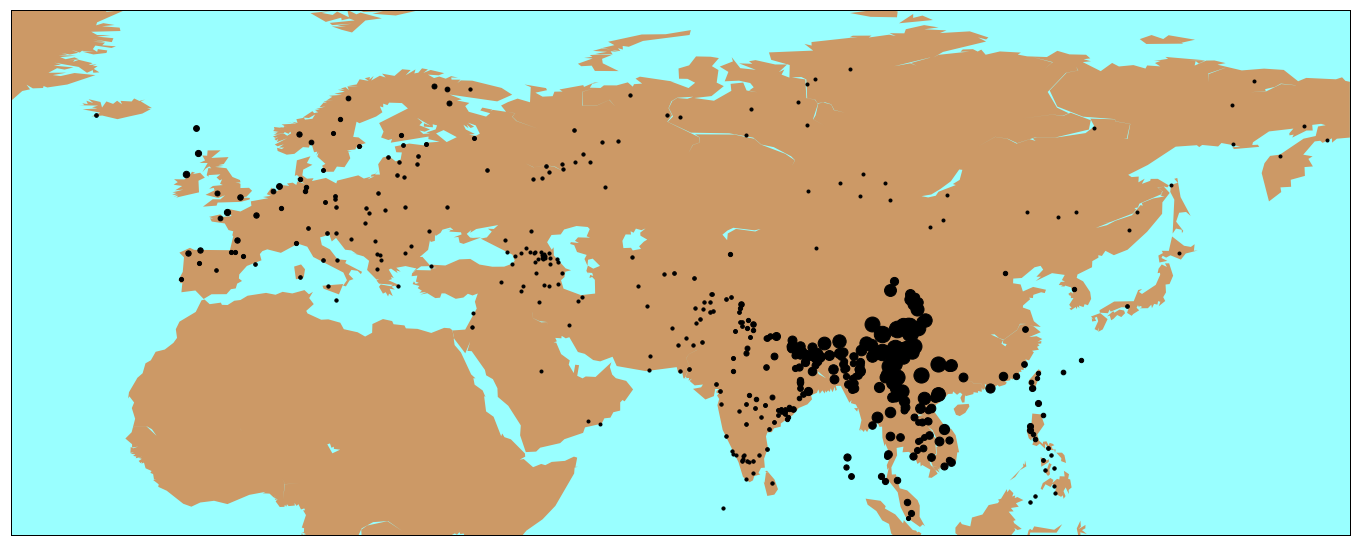

In [28]:
plot_density_map('voiceless nasal')

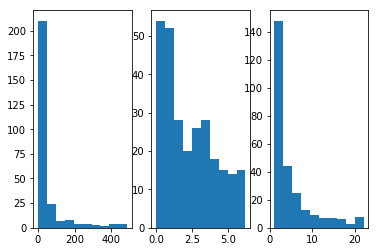

In [35]:
combs_counts = []
for c in combs:
    combs_counts.append(len(big_engine.features_query(c)))
plt.subplot(131)
_ = plt.hist(combs_counts)
plt.subplot(132)
_ = plt.hist(np.log(combs_counts))
plt.subplot(133)
_ = plt.hist(np.sqrt(combs_counts))

In [26]:
phylo_dic = { item.split('#')[0] : value for item, value in big_engine.family_group_dic.items() }
phylo_dic['Russian (Standard)']

['Indo-European', 'Slavic']

In [93]:
# Compute density distributions for all feature combinations
# and put them in a data frame for subsequent analysis.
# Then repeat the procedure taking into account
# only the languages from the same phylum as the
# language of interest.
dataframe_dic = {
    'lang': [],
    'density': [],
    'feature_present': [],
    'feature_name': [],
    'genus': [],
    'phylum': []
}

for c in combs:
    print(c, end = '; ')
    point_list = set(get_point_list(c,
                                    big_engine,
                                    names_dict))
    # Filter the point list
    densities = compute_density_distribution(lang_graph,
                                             point_list,
#                                              exponential_density)
                                             exp_dens_base_2)
    for key in densities:
        dataframe_dic['lang'].append(names[key])
        dataframe_dic['density'].append(densities[key])
        if key in point_list:
            dataframe_dic['feature_present'].append(1)
        else:
            dataframe_dic['feature_present'].append(0)
        phylum, genus = phylo_dic[names[key]]
        dataframe_dic['genus'].append(genus)
        dataframe_dic['phylum'].append(phylum)
        dataframe_dic['feature_name'].append(c)

dd_dataframe = pd.DataFrame(dataframe_dic)
dd_dataframe.to_csv('neighbour_pressure_Nov2017.csv', index=False)

bilabial plosive voiceless; bilabial plosive voiceless palatalised; bilabial plosive voiceless labialised; bilabial plosive voiceless aspirated; bilabial plosive voiceless glottalised; bilabial plosive voiceless aspirated palatalised; bilabial plosive voiceless glottalised palatalised; bilabial plosive voiceless aspirated labialised; bilabial plosive voiceless glottalised labialised; bilabial plosive voiced; bilabial plosive voiced palatalised; bilabial plosive voiced labialised; bilabial plosive voiced aspirated; bilabial implosive voiced; bilabial nasal voiceless; bilabial nasal voiceless palatalised; bilabial nasal voiced; bilabial nasal voiced palatalised; bilabial nasal voiced labialised; bilabial nasal voiced aspirated; bilabial fricative voiceless; bilabial fricative voiced; bilabial fricative voiced palatalised; bilabial affricate voiceless; bilabial affricate voiced; bilabial affricate voiced palatalised; labial-velar approximant voiceless; labial-velar approximant voiced; lab

In [37]:
# Compute density distributions for all feature combinations
# and put them in a data frame for subsequent analysis.
# Then repeat the procedure taking into account
# only the languages from the same phylum as the
# language of interest.
dataframe_dic = {
    'lang': [],
    'density': [],
    'feature_present': [],
    'feature_name': [],
    'genus': [],
    'phylum': []
}

for c in combs:
    print(c, end = '; ')
    point_list = set(get_point_list(c,
                                    big_engine,
                                    names_dict))
    # Filter the point list
    densities = compute_density_distribution_from_the_same_phylum(lang_graph,
                                                                  point_list,
#                                              exponential_density)
                                                                  exp_dens_base_2,
                                                                  phylo_dic,
                                                                  names)
    for key in densities:
        dataframe_dic['lang'].append(names[key])
        dataframe_dic['density'].append(densities[key])
        if key in point_list:
            dataframe_dic['feature_present'].append(1)
        else:
            dataframe_dic['feature_present'].append(0)
        phylum, genus = phylo_dic[names[key]]
        dataframe_dic['genus'].append(genus)
        dataframe_dic['phylum'].append(phylum)
        dataframe_dic['feature_name'].append(c)

dd_dataframe = pd.DataFrame(dataframe_dic)
dd_dataframe.to_csv('neighbour_pressure_same_phylum.csv', index=False)

bilabial plosive voiceless; bilabial plosive voiceless palatalised; bilabial plosive voiceless labialised; bilabial plosive voiceless aspirated; bilabial plosive voiceless glottalised; bilabial plosive voiceless aspirated palatalised; bilabial plosive voiceless glottalised palatalised; bilabial plosive voiceless aspirated labialised; bilabial plosive voiceless glottalised labialised; bilabial plosive voiced; bilabial plosive voiced palatalised; bilabial plosive voiced labialised; bilabial plosive voiced aspirated; bilabial implosive voiced; bilabial nasal voiceless; bilabial nasal voiceless palatalised; bilabial nasal voiced; bilabial nasal voiced palatalised; bilabial nasal voiced labialised; bilabial nasal voiced aspirated; bilabial fricative voiceless; bilabial fricative voiced; bilabial fricative voiced palatalised; bilabial affricate voiceless; bilabial affricate voiced; bilabial affricate voiced palatalised; labial-velar approximant voiceless; labial-velar approximant voiced; lab

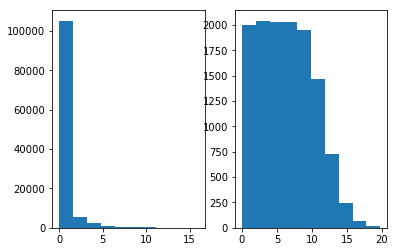

In [37]:
plt.subplot(121)
_ = plt.hist(dd_dataframe[dd_dataframe['feature_present'] == 0]['density'])
plt.subplot(122)
_ = plt.hist(dd_dataframe[dd_dataframe['feature_present'] == 1]['density'])

In [2]:
import sys
print(sys.executable)

/Users/macbook/miniconda2/envs/py35/bin/python


See the **predicting-assemblages** notebook for the analysis of the data.